<a href="https://colab.research.google.com/github/Marzieh777/Fraud-Detection-Crime-Rating/blob/master/crime_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import necessary pachages:
import pandas as pd
import gzip
import numpy as np

import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from  sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
import sklearn.linear_model as linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plot
from sklearn import linear_model
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#set up google colab for reading data (the work was done on google colab)

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


#Preprocessing 
* fill nan values
*  encoding categorical data


#Explore data set and fill Nan Values

In [4]:
path_data= '/content/drive/My Drive/Colab Notebooks/crime_prep.csv.gz'
data = pd.read_csv(path_data, compression='gzip', header=0, sep=',', quotechar='"')
#dataset_train = pd.read_csv(path_data)
print(data.shape)
print(data.info())
print(data.head())
#crime_df = data.fillna(0)
#print(crime_df.head())


(1994, 128)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, target to v_cont_126
dtypes: float64(125), int64(2), object(1)
memory usage: 1.9+ MB
None
   target  v_cont_0  v_cat_0  ...  v_cont_124 v_cont_125  v_cont_126
0    0.20         8      NaN  ...         0.5       0.32        0.14
1    0.67        53      NaN  ...         NaN       0.00         NaN
2    0.43        24      NaN  ...         NaN       0.00         NaN
3    0.12        34      5.0  ...         NaN       0.00         NaN
4    0.03        42     95.0  ...         NaN       0.00         NaN

[5 rows x 128 columns]


In [5]:
#NaN values for categorical and numerical:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

crime_df= DataFrameImputer().fit_transform(data)
print(crime_df.head())

   target  v_cont_0    v_cat_0  ...  v_cont_124 v_cont_125  v_cont_126
0    0.20         8  58.826829  ...    0.500000       0.32    0.140000
1    0.67        53  58.826829  ...    0.440439       0.00    0.195078
2    0.43        24  58.826829  ...    0.440439       0.00    0.195078
3    0.12        34   5.000000  ...    0.440439       0.00    0.195078
4    0.03        42  95.000000  ...    0.440439       0.00    0.195078

[5 rows x 128 columns]


## The first approache is to see the problem as a classification task, So we need to create a new column that shows high crime and lower crime rates, we can put a threshold and change it as it is required. here we put threshold as 0.2, and it can be higher or lower

In [6]:
def set_new_label(df):
    '''Function to set value of highCrime depending on ViolentCrimesPerPop'''
    if df['target'] > 0.2:
        return True
    else:
        return False
    
# Adding a new column named "target2"
crime_df['target2'] = crime_df.apply(set_new_label, axis=1)


# Calculating the percentage of True and False instances in the dataset
portions = crime_df.groupby('target2').size() * 100 / len(crime_df)
print(portions)

print("Percentage high rate of crime = {}\nPercentage low rate of crime = {} ".format(portions[1],portions[0]))

target2
False    59.578736
True     40.421264
dtype: float64
Percentage high rate of crime = 40.42126379137412
Percentage low rate of crime = 59.57873620862588 


#splitting data and fix a seed


In [7]:
SEED =1333
train_df, test_df = train_test_split(crime_df, test_size=0.2, random_state=SEED)
print(train_df.dtypes)

target        float64
v_cont_0        int64
v_cat_0       float64
v_cat_1       float64
v_cat_2        object
               ...   
v_cont_123    float64
v_cont_124    float64
v_cont_125    float64
v_cont_126    float64
target2          bool
Length: 129, dtype: object


## Drop non predictive features and split target and features
* since we have one categorical feature, we ignore it for now and will noe encode it.

In [8]:
#Dropping non predictive columns to obtain features
X = train_df.drop('target', axis=1).drop('target2', axis=1).drop('v_cat_2',axis =1)
print(X.info())
features = list(X.columns)
y = train_df["target2"]

X_test = test_df.drop('target', axis=1).drop('target2', axis=1).drop('v_cat_2',axis =1)
y_test= test_df["target2"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1595 entries, 189 to 377
Columns: 126 entries, v_cont_0 to v_cont_126
dtypes: float64(124), int64(2)
memory usage: 1.5 MB
None


# First model is Decision threes with no max depth, 

In [9]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X,y)
predictions = tree_clf.predict(X[features])
recall_score = metrics.recall_score(train_df['target2'], predictions)
precision_score = metrics.precision_score(train_df['target2'], predictions)
accuracy_score = metrics.accuracy_score(train_df['target2'], predictions)
print("Accuracy Train = {} Precision Train = {} Recall Train = {}".format(accuracy_score,precision_score,recall_score))

test_predicted = tree_clf.predict(X_test[features])
test_recall_score = metrics.recall_score(test_df['target2'], test_predicted)
test_precision_score = metrics.precision_score(test_df['target2'],test_predicted)
test_accuracy_score = metrics.accuracy_score(test_df['target2'], test_predicted)
print("Accuracy Test= {} Precision Test= {} Recall Test = {}".format(test_accuracy_score,test_precision_score,test_recall_score))

Accuracy Train = 1.0 Precision Train = 1.0 Recall Train = 1.0
Accuracy Test= 0.7869674185463659 Precision Test= 0.7534246575342466 Recall Test = 0.6918238993710691


#To avoid overfitting we should choose the best  hyperparameter 'DEPTH' in decision tree
* we will do a grid search along with CROSS-VALIDATION
 on different depths, particularly small values since higher depths are the cause of overfitting

In [10]:

#cross validation to avoid overfitting
for depth in range(1,10):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    if clf.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_clf, X, y,scoring='accuracy', cv=10, n_jobs=1))
    print("Depth: %i Accuracy: %.3f" % (depth,score))


Depth: 1 Accuracy: 0.774
Depth: 2 Accuracy: 0.766
Depth: 3 Accuracy: 0.777
Depth: 4 Accuracy: 0.775
Depth: 5 Accuracy: 0.774
Depth: 6 Accuracy: 0.775
Depth: 7 Accuracy: 0.781
Depth: 8 Accuracy: 0.776
Depth: 9 Accuracy: 0.772


# We observe that the accuracy is higher in depth 7, So we choose it as our best hyperparameter

In [11]:
bestTree_clf = DecisionTreeClassifier(max_depth=7)
bestTree_clf.fit(X,y)

#Predict on Train 
pred_train= bestTree_clf.predict(X)
train_accuracy= metrics.accuracy_score(train_df['target2'], pred_train)
train_precision= metrics.precision_score(train_df['target2'], pred_train)
train_recall= metrics.recall_score(train_df['target2'], pred_train)

print("Train Accuracy of Optimal decision tree  =",train_accuracy)
print("Train Precision of Optimal decision tree  =",train_precision)
print("Train Recall of Optimal decision tree =",train_precision)

#predict on Test
test_pred= bestTree_clf.predict(X_test)
test_accuracy= metrics.accuracy_score(test_df['target2'],test_pred)
test_precision= metrics.precision_score(test_df['target2'], test_pred)
test_dt_recall= metrics.recall_score(test_df['target2'], test_pred)
print("TEST Accuracy of Optimal decision tree=",test_accuracy)
print("TEST Precision of Optimal decision tree  =",test_precision)
print("TEST Recall of Optimal decision tree =",test_precision)

Train Accuracy of Optimal decision tree  = 0.9385579937304075
Train Precision of Optimal decision tree  = 0.926905132192846
Train Recall of Optimal decision tree = 0.926905132192846
TEST Accuracy of Optimal decision tree= 0.8095238095238095
TEST Precision of Optimal decision tree  = 0.7785234899328859
TEST Recall of Optimal decision tree = 0.7785234899328859


#Appply 10 fold Cross validation to make sure about the performance on training, since we have a small amount of data:

In [12]:
# Applying 10 fold cross validation
X_all = crime_df.drop('target', axis=1).drop('target2', axis=1).drop('v_cat_2',axis =1)
y_all = crime_df['target2']

dt_cv_accuracy = cross_val_score(bestTree_clf, X_all, y_all, cv=10).mean()
dt_cv_precision= cross_val_score(bestTree_clf, X_all, y_all, cv=10, scoring='precision').mean()
dt_cv_recall = cross_val_score(bestTree_clf, X_all, y_all, cv=10, scoring='recall').mean()
print("Cross Validation Accuracy DT:", dt_cv_accuracy)
print("Cross Validation Recall DT:", dt_cv_precision)
print("Cross Validation Precision DT:", dt_cv_recall)

Cross Validation Accuracy DT: 0.8079572864321607
Cross Validation Recall DT: 0.7713883821560177
Cross Validation Precision DT: 0.7555092592592592


# Linear classifier (Guassian NB)

In [13]:
# Using GaussianNB
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_all, y_all)

# Applying 10 fold cross validation
gaussian_accuracy = cross_val_score(gaussian_clf, X_all, y_all, cv=10).mean()
gaussian_precision= cross_val_score(gaussian_clf, X_all, y_all, cv=10, scoring='precision').mean()
gaussian_recall = cross_val_score(gaussian_clf, X_all, y_all, cv=10, scoring='recall').mean()
print("Accuracy for gaussian :", gaussian_accuracy)
print("Recall for gaussian:", gaussian_recall)
print("Precision for gaussian:", gaussian_precision)


Accuracy for gaussian : 0.8009246231155778
Recall for gaussian: 0.6129629629629629
Precision for gaussian: 0.8556165730574232


#Get high predictive features:

In [14]:
df_predictiveFeature = train_df
#Predictive features
dictPredFeature = {}
# Collecting data for the two classes
true_df = X[df_predictiveFeature['target2'] == 1]
false_df = X[df_predictiveFeature['target2'] == 0]
for column in X:
    mean_true = true_df[column].mean()
    mean_false = false_df[column].mean()
    var_true = true_df[column].var()
    var_false = false_df[column].var()
    if(column != 'target2'):
        predScore = abs((mean_true - mean_false))/(math.sqrt(var_true)+math.sqrt(var_false))
        dictPredFeature[column] = predScore
most_pred_features = sorted(dictPredFeature.items(), key=lambda x: x[1])[-10:]
for i in most_pred_features:
    print(i)

('v_cont_22', 0.6398472929576984)
('v_cont_46', 0.649685455689602)
('v_cont_51', 0.6665383519740923)
('v_cont_45', 0.6736392678208543)
('v_cont_20', 0.6916744011007128)
('v_cont_50', 0.7052784469750342)
('v_cont_8', 0.7251858187026683)
('v_cont_55', 0.772674856506202)
('v_cont_48', 0.7761155280364557)
('v_cont_49', 0.8495786797491576)


#Plotting results (accuracy, precision, recall) on Guassian and decision Tree to compare them

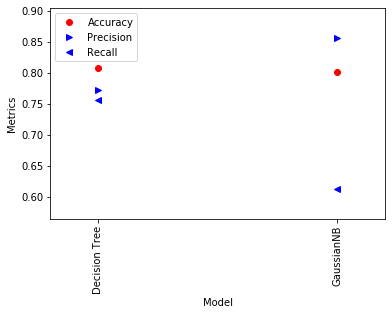

In [15]:
labels = ["Decision Tree" ,"GaussianNB"]
acc = [dt_cv_accuracy,gaussian_accuracy]
pre = [dt_cv_precision,gaussian_precision]
re = [dt_cv_recall,gaussian_recall]

x_axis_range = range(2)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre,'>',color="blue",label="Precision")
plt.plot(x_axis_range,re,'<',color="blue",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

#SVM Classifier:


In [0]:
svm_clf = svm.SVC(kernel='linear', C =1.0)
accuracy_svm = cross_val_score(svm_clf, X_all, y_all, scoring='accuracy').mean()
precision_svm = cross_val_score(svm_clf, X_all, y_all, scoring='precision').mean()
recall_svm = cross_val_score(svm_clf, X_all, y_all, scoring='recall').mean()
print ('Accuracy for SVM ', accuracy_svm)
print ('Precision for SVM ', precision_svm)
print ('Recall for SVM', recall_svm)

In [21]:
#Implementing XG-boost #max_depth= 10
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 15,
                n_estimators=1000,
                learning_rate=1,
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 4,
                seed=SEED)

#fit classifier with eval_metric=AUC_PR, 
xgb_clf.fit(X_all, y_all)
acc_xgb= cross_val_score(clf, X_all, y_all, cv=10, scoring='accuracy').mean()
pr_xgb = cross_val_score(clf, X_all, y_all, cv=10, scoring='precision').mean()
re_xgb = cross_val_score(clf, X_all, y_all, cv=10, scoring='recall').mean()
print ('Accuracy XGB_Classifier', acc_xgb)
print ('Precision  XGB_Classifier', pr_xgb)
print ('Recall for XGB_Classifier', re_xgb)

Accuracy XGB_Classifier 0.7979120603015075
Precision  XGB_Classifier 0.7463143656050925
Recall for XGB_Classifier 0.7604012345679012


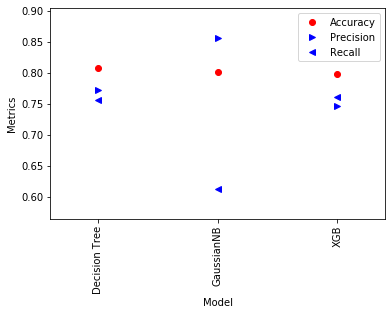

In [22]:
labels = ["Decision Tree" ,"GaussianNB", "XGB"]
acc = [dt_cv_accuracy,gaussian_accuracy,acc_xgb]
pre = [dt_cv_precision,gaussian_precision,pr_xgb]
re = [dt_cv_recall,gaussian_recall,re_xgb]

x_axis_range = range(3)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre,'>',color="blue",label="Precision")
plt.plot(x_axis_range,re,'<',color="blue",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()